# Concise Text Classification Prototype

### Objective: 

Classify text for potential action in the setting of ambiguous representations, succinctness, and restricted, domain-specific vocabulary. 

### Methods: 

* Internal corpus embedding (Word2Vec)
* LSTM classifier architectures:
    1. Many-to-one; 
    2. Bidirectional Many-to-One.

### Prototype Dataset: 

* Description: Medical notes collected at a call center for ticketing/handling purposes.
* Location: Kaggle [(link here)](https://www.kaggle.com/jsreddy79/text-classification-supervised-learning#TextClassification_Data.csv).

## Modules:

In [743]:
import pandas as pd
import csv
import collections
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import random
import math
import string
import itertools
import tensorflow as tf
from sklearn.manifold import TSNE
import time
import copy

## Data Import/Initial Processing:

Note: `encoding = "ISO-8859-1"` in `pd.read_csv` deals with UTF encoding errors. 

In [744]:
pre_data = pd.read_csv('Loves_Consult//TextClassification_Data.csv', encoding = "ISO-8859-1")
pre_data.head()

,fileid,SUMMARY,DATA,categories,sub_categories,previous_appointment,ID
0,2015561331001,Pt aware that he needs ROV for refill,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,PRESCRIPTION,REFILL,No,2015_5_6133_1001
1,2015561341001,Mom wants to know if the Focalin needs some do...,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,ASK_A_DOCTOR,MEDICATION RELATED,No,2015_5_6134_1001
2,2015561351001,pt called to discuss nortryptiline. she says s...,xxxx-xxxx\f0 \fswiss Arial;}}{\colortbl ;\red2...,ASK_A_DOCTOR,MEDICATION RELATED,No,2015_5_6135_1001
3,2015561361001,FYI Nortryptline medication.,xxxx-xxxx\f0 \fswiss Arial;}}{\colortbl ;\red2...,MISCELLANEOUS,OTHERS,No,2015_5_6136_1001
4,2015561371001,Letter of patient establishment request,{\rtf1\ansi\ftnbj{\fonttbl{\f0 \fswiss Arial;}...,MISCELLANEOUS,"SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)",No,2015_5_6137_1001


Reduce dataset to text and action category, drop unecessary data points and fix category errors. 

In [745]:
pre_data = pre_data[['SUMMARY', 'categories']].dropna()
pre_data.head()

,SUMMARY,categories
0,Pt aware that he needs ROV for refill,PRESCRIPTION
1,Mom wants to know if the Focalin needs some do...,ASK_A_DOCTOR
2,pt called to discuss nortryptiline. she says s...,ASK_A_DOCTOR
3,FYI Nortryptline medication.,MISCELLANEOUS
4,Letter of patient establishment request,MISCELLANEOUS


In [746]:
print(collections.Counter(pre_data['categories']))

Counter({'PRESCRIPTION': 14500, 'APPOINTMENTS': 12960, 'ASK_A_DOCTOR': 11743, 'MISCELLANEOUS': 10460, 'LAB': 4246, 'JUNK': 20, 'mISCELLANEOUS': 3, 'asK_A_DOCTOR': 1})


In [747]:
def fix(data_frame):
    junk_list = list(data_frame[data_frame['categories'] == 'JUNK'].index)
    data_frame = data_frame.drop(junk_list, axis = 0)
    data_frame = data_frame.replace(['mISCELLANEOUS', 'asK_A_DOCTOR'], ['MISCELLANEOUS','ASK_A_DOCTOR'])
    return data_frame

pre_data = fix(pre_data)
print(collections.Counter(pre_data['categories']))

Counter({'PRESCRIPTION': 14500, 'APPOINTMENTS': 12960, 'ASK_A_DOCTOR': 11744, 'MISCELLANEOUS': 10463, 'LAB': 4246})


## Data Balancing:

Randomly upsample (generally with replacement) either to the maximum representation or with a linear regression. 

#### Important Note:

The upsampling is executed prior to the embedding, which might effect representation geometry in a positive or negative manner. 

In [771]:
def max_balance(data_frame, class_key):
    out_data_frame = copy.deepcopy(data_frame)
    class_counter = collections.Counter(out_data_frame[class_key])
    class_max = class_counter[max(class_counter)]
    for key in class_counter.keys():
        difference = class_max - class_counter[key]
        if difference > 0:
            sample_data = out_data_frame[out_data_frame[class_key] == key].sample(n = difference, replace = True)
            out_data_frame = out_data_frame.append(sample_data, ignore_index = True)
    return out_data_frame

test_max_balance = max_balance(pre_data, class_key = 'categories')
print('=====================')
print(collections.Counter(test_max_balance['categories']))
print('=====================')
del test_max_balance

def simple_list_regression(list_of_values):
    list_of_values.sort()
    y = list_of_values
    x_n = len(y)-1
    x_bar = x_n/2
    y_bar = sum(y)/len(y)
    beta_numerator = sum([(i - x_bar)*(y[i]-y_bar) for i in range(len(y))])
    beta_denominator = sum([(i-x_bar)*(i-x_bar) for i in range(len(y))])
    beta = beta_numerator/beta_denominator
    alpha = y_bar - beta*x_bar
    return (alpha, beta)

def regression_balance(data_frame, 
                       class_key = False, 
                       upsample = True, 
                       downsample = False,
                       halt_after_intersect = True,
                       randomize_output = True, 
                       replace = True,
                       random_state = None):
    assert class_key, 'regression_balance: You must specify a class key.'
    out_data_frame = copy.deepcopy(data_frame)
    class_counter = collections.Counter(out_data_frame[class_key])
    count_keys = list(class_counter.keys())
    count_keys.reverse()
    count_list = list(class_counter.values())
    count_list.reverse()
    reg_coeff = simple_list_regression(count_list)
    intersect = 0
    for i in range(len(count_keys)):
        key = count_keys[i]
        difference = int(math.floor(reg_coeff[1]*i+reg_coeff[0]))-count_list[i]
        if difference > 0 and upsample and intersect == 0:
            sample_data = out_data_frame[out_data_frame[class_key] == key].sample(n = difference, replace = replace, 
                                                                          random_state = random_state)
            out_data_frame = out_data_frame.append(sample_data, ignore_index = True)
        elif difference == 0:
            continue
        elif difference < 0:
            if halt_after_intersect:
                intersect += 1
            if downsample:
                sample_data = out_data_frame[out_data_frame[class_key] == key].sample(n = -difference, replace = False, 
                                                                          random_state = random_state)
                drop_indices = list(sample_data.index)
                out_data_frame = out_data_frame.drop(drop_indices, axis = 0)
    if randomize_output:
        out_data_frame = out_data_frame.sample(frac=1).reset_index(drop=True)
    return out_data_frame

test_reg_balance = regression_balance(pre_data, class_key = 'categories')
print('=====================')
print(collections.Counter(test_reg_balance['categories']))
print('=====================')
del test_reg_balance

Counter({'PRESCRIPTION': 14500, 'ASK_A_DOCTOR': 14500, 'MISCELLANEOUS': 14500, 'APPOINTMENTS': 14500, 'LAB': 14500})
Counter({'PRESCRIPTION': 14500, 'APPOINTMENTS': 12960, 'ASK_A_DOCTOR': 11744, 'MISCELLANEOUS': 10463, 'LAB': 6181})


#### Illustration of Regression Balancing:

Regression Coefficients: (intercept, slope) = (6181.6, 2300.5)


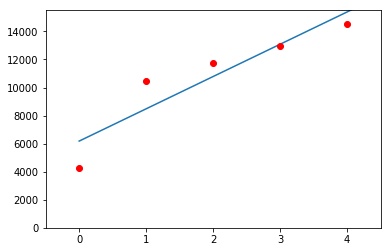

In [772]:
# Plot of regression line and original class counts. 

original_class_counts = list(collections.Counter(pre_data['categories']).values())
original_reg_coeff = simple_list_regression(original_class_counts)
print('Regression Coefficients: (intercept, slope) = '+ str(original_reg_coeff))
def f(x):
    return original_reg_coeff[1]*x + original_reg_coeff[0]

fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, len(original_class_counts), 1000)
ax.plot(x, f(x))

original_class_counts.sort()
plt.plot(range(len(original_class_counts)), original_class_counts, 'ro')
plt.axis([-0.5, 4.5, 0, max(original_class_counts) + 1000])
plt.show()

In [773]:
balanced_data = regression_balance(pre_data, class_key = 'categories')

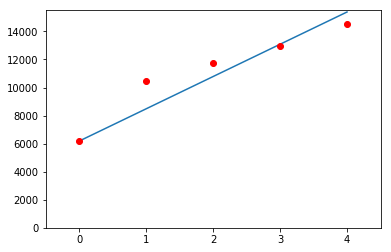

In [774]:
# Plot of regression line and balanced class counts. 

class_counts = list(collections.Counter(balanced_data['categories']).values())

def f(x):
    return original_reg_coeff[1]*x + original_reg_coeff[0]

fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 4, 1000)
ax.plot(x, f(x))

class_counts.sort()
plt.plot(range(len(class_counts)),class_counts,'ro')
plt.axis([-0.5, 4.5, 0, max(class_counts)+1000])
plt.show()

# Data Formatting

In [775]:
data_array = balanced_data.values[...,0]
labels_array = balanced_data.values[...,1]

### Encoding Labels

In [776]:
def encode_labels(labels, print_stats = True):
    unique_labels = np.unique(labels)
    identity = (unique_labels == unique_labels[:,None]).astype(np.float32)
    lookup_dict = dict(zip(unique_labels.tolist(), [identity[i] for i in range(identity.shape[0])]))
    out_labels = (unique_labels == labels[:,None]).astype(np.float32)
    def lookup_function(label):
        return lookup_dict[label]
    def reverse_lookup_function(encoded_label):
        rev_look = [x for x,y in lookup_dict.items() if np.array_equal(y, encoded_label)]
        return rev_look[0]
    def decode_labels(encoded_label_array):
        return np.array([reverse_lookup_function(encoded_label_array[i]) for i in range(encoded_label_array.shape[0])])
    if print_stats:
        if np.array_equal(decode_labels(out_labels), labels):
            print('Successful label encoding.')
            print('Number of classes: ' + str(unique_labels.shape[0]))
            print('Number of labels: ' + str(out_labels.shape[0]))
        else:
            print('Bijection failure.')
    return out_labels, lookup_function, reverse_lookup_function, decode_labels

labels, label2vec, vec2label, decode_labels = encode_labels(labels_array)

Successful label encoding.
Number of classes: 5
Number of labels: 55848


## Word Embedding: Internal Corpus Word2Vec

### Corpus Construction and Frequency Encoding

In [793]:
stop_list = [".",",","!","?",":",";","/","(",")","-", "\ufeff", "\"", "\'s"]
measurements = ["mg", "cc", "lb", "lbs", "kg", "kgs"]
end_signature = '[..end..]'

# Owed: use number before 'mg' and space after to split 'mg' from drug measurements.

def format_string(string):
    global stop_list
    global measurements
    for item in stop_list:
        string = string.replace(item, " " + item + " ")
    for item in measurements:
        if item in string:
            index = string.find(item)
            if ord(string[index - 1]) in range(48,58):
                string = string[:index] + " " + string[index:]
    return string.lower()

def strings2list(column, report = True, n_most_common = 20):
    # input: 1D numpy array of strings.
    # output: list of words, spaced punctuation, and end token.
    global end_signature
    out_list = []
    for i in range(column.shape[0]):
        if isinstance(column[i], str):
            instance_list = format_string(column[i]).split() + [end_signature]
            out_list = out_list + instance_list
        else:
            print('Entry not a string at index ' + str(i))
    frequency_dictionary = collections.Counter(out_list)
    dictionary = dict()
    for word, _ in frequency_dictionary.most_common():
        dictionary[word] = len(dictionary) 
    def print_stats():
        print(str(len(out_list)) + " instances across " + str(len(frequency_dictionary)) + " distinct.")
        print("%d most common words: " % n_most_common, end = "")
        print(dict(frequency_dictionary.most_common(n_most_common)))
    if report:
        print_stats()
    reverse_dictionary = dict(zip(dict(dictionary).values(), dict(dictionary).keys()))
    return out_list, dictionary, reverse_dictionary, dict(frequency_dictionary)

words_list, dictionary, reverse_dictionary, frequency_dictionary = strings2list(data_array, n_most_common = 100)

418533 instances across 10763 distinct.
100 most common words: {'[..end..]': 55848, '/': 17802, 'to': 11882, 'pt': 11066, 'rx': 8698, '-': 8295, '.': 6841, ',': 5703, 'for': 5685, 'appt': 4658, ':': 4640, 'request': 4077, 'phone': 4074, 'note': 3995, 'refill': 3706, 'on': 3455, 'mri': 3425, 'call': 3281, '15': 3141, 'with': 3102, 'and': 3036, 'results': 3027, 'in': 2487, 'rov': 2317, 'a': 2169, 'dr': 2100, "'s": 2075, 'of': 2028, 'please': 1878, 'mom': 1693, '?': 1618, 'clld': 1614, 'the': 1609, 'from': 1577, 'order': 1489, 'scheduled': 1427, 'patient': 1406, 'needs': 1404, 'w': 1404, 'called': 1397, 'about': 1393, '1': 1351, 'calling': 1279, '2015': 1278, 'new': 1265, 'is': 1263, '2': 1251, 'rn': 1241, 'at': 1201, '3': 1193, 'like': 1185, 'would': 1155, '@': 1113, 'requesting': 1106, 'add': 1105, 'work': 1072, 'wants': 1068, 'pa': 1068, 'today': 1038, 'not': 1003, 'pls': 997, 'need': 991, 'discuss': 963, 'faxed': 953, '6': 947, 'sch': 947, 'records': 947, 'eeg': 930, 'referral': 929, 

Note: The dataset may not be large enough for meaningful relations to be developed.  A larger corpus of loose medical notes probably should be mined for more meaningful relations in production. Additionally, a larger corpus would be needed beyond the closed classification problem for unexpected values. 

In [794]:
numerically_encoded_corpus = [dictionary[word] for word in words_list]
for number in numerically_encoded_corpus[:100]:
    print(reverse_dictionary[number], end = " ")
del words_list

hydrocodone rx built [..end..] keppra rx to express scripts [..end..] mri order faxed [..end..] daughter wants a work in appt with klh due to symptoms worsening [..end..] rx refill oxycodon and morphine [..end..] md change request [..end..] phone note [..end..] behavior [..end..] neuropsych order ? requesting mri results . [..end..] new rx request - amrix [..end..] pt clld to schedule an appt in concussion clinic [..end..] dr . office wants to know if test will be ordered [..end..] mysoline rx clarification [..end..] another msg is open about this patient [..end..] rx clarification on tecfidera [..end..] sumatriptan rx [..end..] pt 's 

## Embedding Model

Skip-gram (5) Word2Vec model with end-acknowledging modification for noise reduction. 

### Batch Generator:

In [795]:
data_index = 0
left_right_index = [0,0]
subsample_words = []

def subsample_keep_probability(frequency_ratio, parameter = 0.001):
    return min(1, (math.sqrt(frequency_ratio/parameter)+1))

def generate_batch_end_acknowledging_skipgram(corpus, 
                                              batch_size = None, 
                                              n_left = 2, 
                                              n_right = 2,
                                              subsample = True):
    global end_signature
    global data_index
    global left_right_index
    global subsample_words
    corpus_size = len(corpus)
    assert isinstance(batch_size, int), "Batch Generator: You must specify a batch size."
    batch = np.ndarray(shape=(batch_size), dtype = np.int32)
    labels = np.ndarray(shape=(batch_size,1), dtype = np.int32)
    record_position = 0
    word_recorded = False
    corpus_size = len(corpus)
    while record_position < batch_size:
        if subsample and corpus[data_index] in subsample_words:
            data_index = (data_index + 1) % corpus_size
            continue
        # Record end signature with identity and move on.
        if corpus[data_index] == dictionary[end_signature]:
            batch[record_position] = corpus[data_index]
            labels[record_position] = corpus[data_index]
            record_position += 1
            data_index = (data_index + 1) % corpus_size
            word_recorded = False
            continue
            
        # Look left.
        for i in range(left_right_index[0], n_left):
            if record_position == batch_size:
                break
            if corpus[data_index - 1 - i] == dictionary[end_signature]:
                break
            if subsample == True and corpus[data_index-1-i] in subsample_words:
                continue
            else:
                batch[record_position] = corpus[data_index]
                labels[record_position] = corpus[data_index - 1 - i]
                word_recorded = True
                left_right_index[0] += 1
                record_position += 1
                
        # Look right.
        for i in range(left_right_index[1], n_right):
            # print(str(left_right_index[1])+' '+str(n_right))
            if record_position == batch_size:
                break
            if corpus[data_index + 1 + i] == dictionary[end_signature]:
                break
            if subsample and corpus[data_index+1+i] in subsample_words:
                continue
            else:
                batch[record_position] = corpus[data_index]
                labels[record_position] = corpus[data_index + 1 + i]
                word_recorded = True
                left_right_index[1] += 1
                record_position += 1
                
        # Record lonely word with identity. 
        if not word_recorded:
            batch[record_position] = corpus[data_index]
            labels[record_position] = corpus[data_index]
            record_position += 1
        if record_position == batch_size:
            break
        # Subsampling decision. 
        if subsample:
            # Move this computation to corpus in future versions.
            frequency_ratio = frequency_dictionary[reverse_dictionary[corpus[data_index]]]/corpus_size 
            probability = subsample_keep_probability(frequency_ratio)
            sample = random.uniform(0,1)
            if sample > probability:
                subsample_words.append(corpus[data_index])
        data_index = (data_index + 1) % corpus_size
        word_recorded = False
        left_right_index = [0,0]
    return batch, labels

# Batch/Label example.
example_batch, example_labels = generate_batch_end_acknowledging_skipgram(numerically_encoded_corpus, 
                                                                          batch_size = 12)
for i in range(10):
    print(reverse_dictionary[numerically_encoded_corpus[i]], end = " ")
print(" ")
print(example_batch)
print(example_labels)
print('Batch 1: ', end = "")
print([reverse_dictionary[x] for x in example_batch])
print('Label 1: ', end = "")
print([reverse_dictionary[x] for x in example_labels.reshape(12)])

hydrocodone rx built [..end..] keppra rx to express scripts [..end..]  
[ 88  88   4   4 146 146   0 166 166   4   4   4]
[[  4]
 [146]
 [ 88]
 [146]
 [  4]
 [ 88]
 [  0]
 [  4]
 [  2]
 [166]
 [  2]
 [585]]
Batch 1: ['hydrocodone', 'hydrocodone', 'rx', 'rx', 'built', 'built', '[..end..]', 'keppra', 'keppra', 'rx', 'rx', 'rx']
Label 1: ['rx', 'built', 'hydrocodone', 'built', 'rx', 'hydrocodone', '[..end..]', 'rx', 'to', 'keppra', 'to', 'express']


### Embedding Graph:

In [797]:
vocabulary_size = len(dictionary)
embedding_size = 128
number_negative_samples = 64
batch_size = 128

Word2Vec_graph = tf.Graph()

with Word2Vec_graph.as_default():
    # Input: Indices of rows to look up. 
    train_data = tf.placeholder(tf.int32, shape = [batch_size])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size,1])
    
    # Variables
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size],
                                               minval = -1.0,
                                               maxval = 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev = 1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    embed = tf.nn.embedding_lookup(embeddings, train_data)
    sampled_softmax_loss = tf.nn.sampled_softmax_loss(weights=softmax_weights, 
                               biases=softmax_biases, 
                               inputs=embed,
                               labels=train_labels, 
                               num_sampled=number_negative_samples, 
                               num_classes=vocabulary_size)
    
    loss = tf.reduce_mean(sampled_softmax_loss)
    
    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Normalized embeddings.
    embedding_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings/embedding_norm
    
    # Maybe Owed: Similarity validation.

### Embedding Session:

In [798]:
max_number_of_iterations = int(10*len(numerically_encoded_corpus)/batch_size)

with tf.Session(graph = Word2Vec_graph) as session:
    start_time = time.time()
    tf.global_variables_initializer().run()
    print('Variables Initialized')
    average_loss = 0
    for iteration in range(max_number_of_iterations):
        batch_data, batch_labels = generate_batch_end_acknowledging_skipgram(numerically_encoded_corpus,
                                                                            batch_size = batch_size)
        feed_dict = {train_data : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if iteration % 2000 == 0 and iteration > 0:
            average_loss = average_loss / 2000
            print('Average loss at iteration %d: %f' % (iteration, average_loss))
            average_loss = 0
    Word2Vec_embeddings = normalized_embeddings.eval()
    print('Embedding complete.')
    end_time = time.time()
    total_time = round((end_time - start_time)/(60*60), 2)
    print('Total time: ' + str(total_time))

Variables Initialized
Average loss at iteration 2000: 3.765058
Average loss at iteration 4000: 3.310584
Average loss at iteration 6000: 3.211807
Average loss at iteration 8000: 3.135788
Average loss at iteration 10000: 3.068971
Average loss at iteration 12000: 3.006983
Average loss at iteration 14000: 2.985911
Average loss at iteration 16000: 2.968263
Average loss at iteration 18000: 2.954344
Average loss at iteration 20000: 2.894034
Average loss at iteration 22000: 2.886782
Average loss at iteration 24000: 2.880414
Average loss at iteration 26000: 2.864175
Average loss at iteration 28000: 2.848521
Average loss at iteration 30000: 2.823150
Average loss at iteration 32000: 2.819818
Embedding complete.
Total time: 0.01


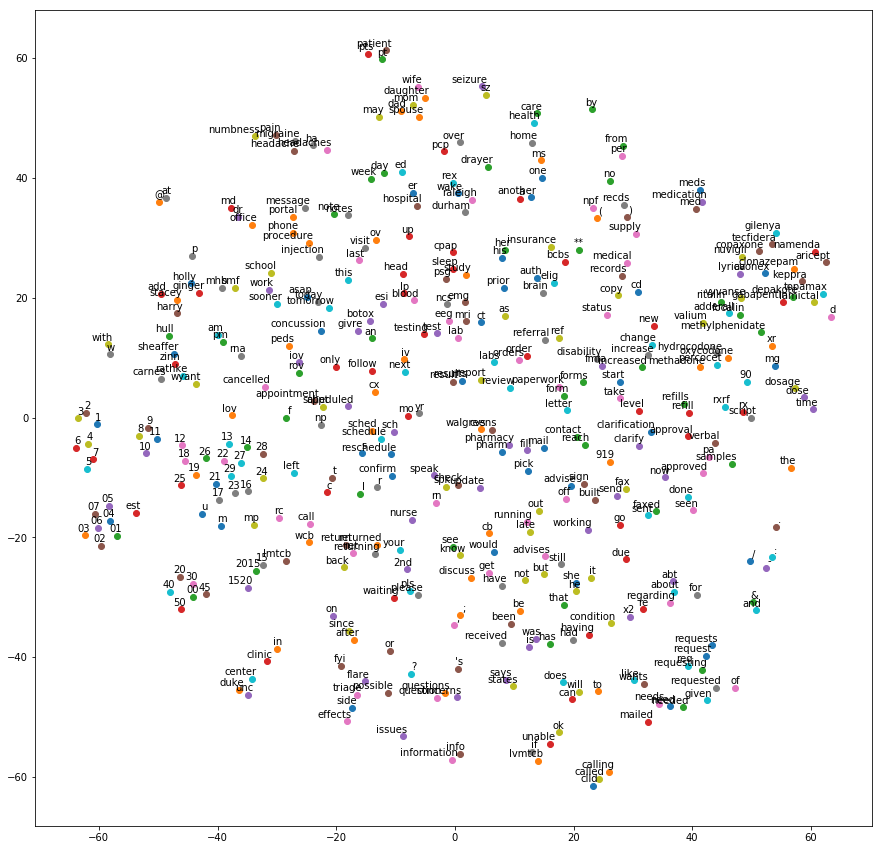

In [799]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(Word2Vec_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

# Sequence Model

## Format Sequences for LSTM

Each string formatted as array of embedding lookup indices (integers). 

In [800]:
def format_data_LSTM(data):
    for i in range(len(data)):
        data[i] = np.array([dictionary[x] for x in format_string(data[i]).split()])
    return data

data_array = format_data_LSTM(data_array)

In [801]:
# Ensure data is not corrupted.

print(data_array[0])
for i in range(len(data_array[0])):
    print(reverse_dictionary[data_array[0][i]], end = " ")

[ 88   4 146]
hydrocodone rx built 

### Sequence Padding:

Sequences padded from left to prevent Many-to-one vanishing problem (failure to train). No initial truncation for fear of information loss in the setting of concise text.

In [802]:
# Find max length of sequence in data.

max_length = 0
for i in range(len(data_array)):
    if len(data_array[i]) > max_length:
        max_length = len(data_array[i])
print(max_length)

28


In [803]:
# Add -1 to the dictionary as the null charater "" and modify the reverse dictionary accordingly.
dictionary[""] = -1
reverse_dictionary[-1] = ""

In [804]:
# Append the 0 vector to the end of Word2Vec_embeddings so that it is referenced for Word2Vec_embeddings[-1].
origin = np.zeros((embedding_size,))
Word2Vec_with_origin = np.append(Word2Vec_embeddings, np.array([origin]), axis = 0)

In [805]:
data_array[:5]

array([array([ 88,   4, 146]), array([166,   4,   2, 585, 467]),
       array([16, 34, 63]),
       array([232,  56,  24,  55,  22,   9,  19, 411, 194,   2, 417, 657]),
       array([   4,   14, 5350,   20,  875])], dtype=object)

In [807]:
def left_padding(sequence_array):
    global max_length
    out_array = copy.deepcopy(sequence_array)
    for i in range(len(out_array)):
        difference = max_length - len(out_array[i])
        fill = np.full((1, difference), -1, dtype=int)
        out_array[i] = np.concatenate((fill, out_array[i]), axis = None)
    return out_array

def right_padding(sequence_array):
    global max_length
    out_array = copy.deepcopy(sequence_array)
    for i in range(len(out_array)):
        difference = max_length - len(out_array[i])
        fill = np.full((1, difference), -1, dtype=int)
        out_array[i] = np.concatenate((out_array[i], fill), axis = None)
    return out_array

left_padded_data = left_padding(data_array)

In [811]:
for i in range(len(left_padded_data[0])):
    print(reverse_dictionary[left_padded_data[0][i]], end = " ")
print("")
for i in range(len(left_padded_data[1])):
    print(reverse_dictionary[left_padded_data[1][i]], end = " ")
print("")    
for i in range(len(left_padded_data[2])):
    print(reverse_dictionary[left_padded_data[2][i]], end = " ")
print("")

                         hydrocodone rx built 
                       keppra rx to express scripts 
                         mri order faxed 


## Balanced Train/Valid/Test Split

In [826]:
def train_valid_test_split(data_array, label_array, 
                           train_test_ratio = .85, 
                           train_valid_ratio = .85, 
                           shuffle_count = 7,
                           print_shapes = True):
    labels = np.unique(label_array, axis = 0) # An array of the distinct entry values occuring in the argument.
    train_indices = []
    test_indices = []
    valid_indices = []
    for label in labels.tolist():
        label_indices = [i for i,x in enumerate(label_array) if np.array_equal(x, label)]
        instance_count = len(label_indices)
        train_test_partition = int(math.floor(train_test_ratio*instance_count))
        random.shuffle(label_indices)
        to_train_valid = label_indices[:train_test_partition]
        to_test = label_indices[train_test_partition:]
        test_indices = test_indices + to_test
        train_valid_partition = int(math.floor(train_valid_ratio*len(to_train_valid)))
        to_train = to_train_valid[:train_valid_partition]
        to_valid = to_train_valid[train_valid_partition:]
        train_indices = train_indices + to_train
        valid_indices = valid_indices + to_valid
    # The iterative shuffling is more an homage than a necessity, but I don't want to dig into
    # the pseudo randomness of random.shuffle.
    for i in range(shuffle_count):
        random.shuffle(train_indices)
        random.shuffle(valid_indices)
        random.shuffle(test_indices)
    train_data = np.stack(data_array[train_indices], axis = 0).astype(int)
    train_labels = label_array[train_indices]
    valid_data = np.stack(data_array[valid_indices], axis = 0).astype(int)
    valid_labels = label_array[valid_indices]
    test_data = np.stack(data_array[test_indices], axis = 0).astype(int)
    test_labels = label_array[test_indices]
    if print_shapes:
        print("Train data shape: " + str(train_data.shape))
        print("Train labels shape: " + str(train_labels.shape))
        print("Valid data shape: " + str(valid_data.shape))
        print("Valid labels shape: " + str(valid_labels.shape))
        print("Test data shape: " + str(test_data.shape))
        print("Test labels shape: " + str(test_labels.shape))
    return train_data, train_labels, valid_data, valid_labels, test_data, test_labels

In [827]:
train_data, train_labels, valid_data, valid_labels, test_data, test_labels = train_valid_test_split(left_padded_data,
                                                                                                    labels)

Train data shape: (40347, 28)
Train labels shape: (40347, 5)
Valid data shape: (7122, 28)
Valid labels shape: (7122, 5)
Test data shape: (8379, 28)
Test labels shape: (8379, 5)


## LSTM Model: Many-to-One

### LSTM Batch Generator

A batch is a 3-dimensional array to be unrolled along axis = 1 (columns). Numerically encoded sequence array is used to pull the Word2Vec embeddings, set along axis = 0. So in short, the batch is a matrix where each row corresponds to a sequence and each entry is a word in the sequence, but replaced by its vector embedding (100 dimensional Word2Vec representation). 

In [828]:
batch_size = 64
number_of_unrollings = max_length # Unroll the LSTM to account for longest sequence. 
number_of_classes = 5
data_index = 0

def generate_LSTM_batch(data_array, label_array, batch_size, number_of_unrollings, embedding_size):
    global data_index
    batch = np.zeros(shape=(batch_size, number_of_unrollings, embedding_size), dtype=np.float32)
    labels = np.zeros(shape=(batch_size, number_of_classes), dtype=np.float32)
    for i in range(batch_size):
        batch[i] = Word2Vec_with_origin[data_array[data_index].astype(int)].reshape(1, number_of_unrollings, embedding_size)
        labels[i] = label_array[data_index]
        data_index = (data_index + 1) % len(data_array)
    return batch, labels

test_batch, test_label = generate_LSTM_batch(train_data, train_labels, batch_size, number_of_unrollings, embedding_size)
print(test_batch.shape)
print(test_label.shape)

valid_total, valid_total_labels = generate_LSTM_batch(valid_data, valid_labels, len(valid_data), number_of_unrollings, embedding_size)
test_total, test_total_labels = generate_LSTM_batch(test_data, test_labels, len(test_data), number_of_unrollings, embedding_size)
print(valid_total.shape)
print(test_total.shape)

(64, 28, 128)
(64, 5)
(7122, 28, 128)
(8379, 28, 128)


### LSTM Cell Math

The state equation: $s_{t}=\sigma(f)\bigodot s_{t-1} + \sigma(i)\bigodot\text{tanh}(c)$

The output equation: $o_{t}=\sigma(o)\bigodot\text{tanh}(s_{t})$

### LSTM Graph:

In [829]:
### Hyperparameters ###
number_of_nodes = 64
initial_learning_rate = 1.
#######################

Basic_LSTM_Mto1_graph = tf.Graph()
with Basic_LSTM_Mto1_graph.as_default():
    # Input
    T = tf.placeholder(tf.float32, shape = [batch_size, number_of_unrollings, embedding_size])
    Tlabel = tf.placeholder(tf.float32, shape = [batch_size, number_of_classes])
    V = tf.constant(valid_total)
    E = tf.constant(test_total)
    # Input gate and linear opertaion.
    X_i = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_i = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_i = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Forget gate and linear opertaion.
    X_f = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_f = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_f = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Memory cell and linear opertaion.                             
    X_c = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_c = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_c = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Output gate and linear opertaion..
    X_o = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_o = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_o = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, number_of_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, number_of_nodes]), trainable=False)
    # Classifier weights and biases.
    W = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_classes], -0.1, 0.1))
    b = tf.Variable(tf.zeros([number_of_classes]))
    
    # Note: in LSTM cell, a sequence_element is batch_size many words at a time step in parallel. 
    def Basic_LSTM_cell(sequence_element, previous_output, state):
        input_gate = tf.sigmoid(tf.matmul(sequence_element, X_i) + tf.matmul(previous_output, M_i) + b_i)
        forget_gate = tf.sigmoid(tf.matmul(sequence_element, X_f) + tf.matmul(previous_output, M_f) + b_f)
        update = tf.matmul(sequence_element, X_c) + tf.matmul(previous_output, M_c) + b_c
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(sequence_element, X_o) + tf.matmul(previous_output, M_o) + b_o)
        return output_gate * tf.tanh(state), state

    # Unrolled LSTM loop.
    output = saved_output
    state = saved_state
    for i in range(number_of_unrollings):
        output, state = Basic_LSTM_cell(T[:,i], output, state)
    
    # Compute logits and loss for last step of LSTM.
    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
        L = tf.nn.xw_plus_b(output, W, b)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = Tlabel, logits=L))
    
    # Decaying learning rate for optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.AdagradOptimizer(learning_rate)    
    # Apply gradient clipping. 
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)
    
    # Training predictions. 
    train_predict = tf.nn.softmax(L)
    
    # Valid predictions. 
    
    valid_saved_output = tf.Variable(tf.zeros([len(valid_total), number_of_nodes]), trainable = False)
    valid_saved_state = tf.Variable(tf.zeros([len(valid_total), number_of_nodes]), trainable = False)
    valid_output = valid_saved_output
    valid_state = valid_saved_state
    for i in range(number_of_unrollings):
        valid_output, valid_state = Basic_LSTM_cell(V[:,i], valid_output, valid_state)
    
    with tf.control_dependencies([valid_saved_output.assign(valid_output),
                                valid_saved_state.assign(valid_state)]):
        Lv = tf.nn.xw_plus_b(valid_output, W, b)
        valid_predict = tf.nn.softmax(Lv)
    
    # Test predictions. 
    
    test_output = tf.Variable(tf.zeros([len(test_total), number_of_nodes]), trainable = False)
    test_state = tf.Variable(tf.zeros([len(test_total), number_of_nodes]), trainable = False)
    for i in range(number_of_unrollings):
        test_output, test_state = Basic_LSTM_cell(E[:,i], test_output, test_state)
    test_predict = tf.nn.softmax(tf.nn.xw_plus_b(test_output, W, b))

In [830]:
def first_order_accuracy(predicted_labels, true_labels):
    return(100*np.sum(np.argmax(predicted_labels, 1)==np.argmax(true_labels, 1))
           /predicted_labels.shape[0])

def vanish_max_axis1(array):
    index = np.argmax(array, 1)
    for i in range(len(array)):
        array[i][index[i]] = 0
    return array

def second_order_accuracy(predicted_labels, true_labels):
    second_predicted_labels = vanish_max_axis1(predicted_labels)
    return(100*np.sum(np.argmax(second_predicted_labels, 1)==np.argmax(true_labels, 1))
           /predicted_labels.shape[0])

### LSTM Many-to-One Session:

In [831]:
number_of_iterations = 10001
train_report_frequency = 1000
valid_report_frequency = 2000
data_index = 0

with tf.Session(graph=Basic_LSTM_Mto1_graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    mean_loss = 0
    for iteration in range(number_of_iterations):
        batch_data, batch_labels = generate_LSTM_batch(train_data, 
                                                       train_labels, 
                                                       batch_size, 
                                                       number_of_unrollings, 
                                                       embedding_size)
        feed_dict = {T : batch_data, Tlabel : batch_labels}
        _, l, train_predictions, lr = session.run([optimizer, loss, train_predict, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        if iteration % train_report_frequency == 0 and iteration > 0:
            mean_loss = mean_loss / train_report_frequency
            print('Iteration %d: average loss = %f, learning rate = %f' % (iteration, mean_loss, lr))
            mean_loss = 0
            train_acc1 = first_order_accuracy(train_predictions, batch_labels)
            train_acc2 = second_order_accuracy(train_predictions, batch_labels)
            print('====== Training Report ======')
            print('First-order accuracy = %.1f%%' % train_acc1)
            print('Second-order accuracy = %.1f%%' % train_acc2)
            if iteration % valid_report_frequency == 0 and iteration > 0:
                valid_predictions = valid_predict.eval()
                valid_acc1 = first_order_accuracy(valid_predictions, valid_total_labels)
                valid_acc2 = second_order_accuracy(valid_predictions, valid_total_labels)
                print('====== Validation Report ======')
                print('First-order validation accuracy = %.1f%%.' % valid_acc1)
                print('Second-order validation accuracy = %.1f%%.' % valid_acc2)
    test_predictions = test_predict.eval()
    test_acc1 = first_order_accuracy(test_predictions, test_total_labels)
    test_acc2 = second_order_accuracy(test_predictions, test_total_labels)
    print('====== Test Report ======')
    print('First-order accuracy: %.1f%%' % test_acc1)
    print('Second-order accuracy: %.1f%%' % test_acc2)
    print('Accuracy when first and second choice are counted: %.1f%%' % (test_acc1+test_acc2))

Initialized
Iteration 1000: average loss = 0.913309, learning rate = 1.000000
====== Training Report ======
First-order accuracy = 71.9%
Second-order accuracy = 14.1%
Iteration 2000: average loss = 0.718920, learning rate = 1.000000
====== Training Report ======
First-order accuracy = 85.9%
Second-order accuracy = 9.4%
====== Validation Report ======
First-order validation accuracy = 73.9%.
Second-order validation accuracy = 14.5%.
Iteration 3000: average loss = 0.688269, learning rate = 1.000000
====== Training Report ======
First-order accuracy = 75.0%
Second-order accuracy = 21.9%
Iteration 4000: average loss = 0.660028, learning rate = 1.000000
====== Training Report ======
First-order accuracy = 82.8%
Second-order accuracy = 7.8%
====== Validation Report ======
First-order validation accuracy = 74.5%.
Second-order validation accuracy = 14.2%.
Iteration 5000: average loss = 0.642799, learning rate = 0.100000
====== Training Report ======
First-order accuracy = 84.4%
Second-order ac

## Bidirectional LSTM Model: Many-to-One

### Batch Generator:

Batch generator modified to handle the vanishing problem in reverse.

In [832]:
null_vector = Word2Vec_with_origin[-1]
data_index = 0

def make_reverse_batch(batch, number_of_unrollings):
    global null_vector
    reverse_data_array = copy.deepcopy(batch)
    for i in range(reverse_data_array.shape[0]):
        for j in range(number_of_unrollings):
            if not np.array_equal(reverse_data_array[i][j], null_vector):
                reverse_row = np.flip(np.flip(reverse_data_array[i][j:], 1))
                reverse_row = reverse_row.reshape(1, reverse_row.shape[0], reverse_row.shape[1])
                fill = np.zeros((1,j,reverse_data_array.shape[2]))
                concat = np.concatenate((fill, reverse_row), axis = 1)
                reverse_data_array[i] = concat
                break
    return reverse_data_array

def generate_Bidirectional_LSTM_batch(data_array, label_array, batch_size, number_of_unrollings, embedding_size):
    global data_index
    forward_batch = np.zeros(shape=(batch_size, number_of_unrollings, embedding_size), dtype=np.float32)
    labels = np.zeros(shape=(batch_size, number_of_classes), dtype=np.float32)
    for i in range(batch_size):
        forward_batch[i] = Word2Vec_with_origin[data_array[data_index].astype(int)].reshape(1, 
                                                                                            number_of_unrollings, 
                                                                                            embedding_size)
        labels[i] = label_array[data_index]
        data_index = (data_index + 1) % len(data_array)
    reverse_batch = make_reverse_batch(forward_batch, number_of_unrollings)
    return forward_batch, reverse_batch, labels

batch_size = 64

test_forward_batch, test_reverse_batch, test_label = generate_Bidirectional_LSTM_batch(train_data, 
                                                                                       train_labels,
                                                                                       batch_size,
                                                                                       number_of_unrollings,
                                                                                       embedding_size)

data_index = 0
valid_forward_total, valid_reverse_total, valid_total_labels = generate_Bidirectional_LSTM_batch(valid_data,
                                                                                                 valid_labels,
                                                                                                 len(valid_data),
                                                                                                 number_of_unrollings,
                                                                                                 embedding_size)

data_index = 0
test_forward_total, test_reverse_total, test_total_labels = generate_Bidirectional_LSTM_batch(test_data,
                                                                                              test_labels,
                                                                                              len(test_data),
                                                                                              number_of_unrollings,
                                                                                              embedding_size)

In [833]:
# Visually inspect test batch to make sure the arrays are flipped correctly. 

break_note = False
for i in range(len(test_forward_total)):
    if break_note:
        break
    for j in range(len(test_forward_total[i])):
        if not np.array_equal(test_forward_total[i][j], null_vector):
            if j == 26:
                print(test_forward_total[i])
                print(test_reverse_total[i])
                break_note = True
            break

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.09431943 -0.05952892 -0.1578434  ... -0.10585922 -0.05620567
   0.02555588]
 [-0.02665923 -0.03021372 -0.01796208 ... -0.07388853 -0.12964542
   0.12687466]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.02665923 -0.03021372 -0.01796208 ... -0.07388853 -0.12964542
   0.12687466]
 [-0.09431943 -0.05952892 -0.1578434  ... -0.10585922 -0.05620567
   0.02555588]]


### Bidirectional LSTM Many-to-One Graph:

In [834]:
### Hyperparameters ###
number_of_nodes = 64 
initial_learning_rate = 1.
batch_size = 64
dropout_keep_probability = .5
#######################

Bidirectional_LSTM_Mto1_graph = tf.Graph()
with Bidirectional_LSTM_Mto1_graph.as_default():
    # Input:
    # Training
    Tforward = tf.placeholder(tf.float32, shape = [batch_size, number_of_unrollings, embedding_size])
    Treverse = tf.placeholder(tf.float32, shape = [batch_size, number_of_unrollings, embedding_size])
    Tlabel = tf.placeholder(tf.float32, shape = [batch_size, number_of_classes])
    # Validation
    Vforward = tf.constant(valid_forward_total)
    Vreverse = tf.constant(valid_reverse_total)
    # Test
    Eforward = tf.constant(test_forward_total)
    Ereverse = tf.constant(test_reverse_total)
    
    # Forward LSTM trainable variables:
    # Input gate and linear opertaion.
    X_for_i = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_for_i = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_for_i = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Forget gate and linear opertaion.
    X_for_f = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_for_f = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_for_f = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Memory cell and linear opertaion.                             
    X_for_c = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_for_c = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_for_c = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Output gate and linear opertaion..
    X_for_o = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_for_o = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_for_o = tf.Variable(tf.zeros([1, number_of_nodes]))
    
    # Reverse LSTM trainable variables:
    # Input gate and linear opertaion.
    X_rev_i = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_rev_i = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_rev_i = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Forget gate and linear opertaion.
    X_rev_f = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_rev_f = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_rev_f = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Memory cell and linear opertaion.                             
    X_rev_c = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_rev_c = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_rev_c = tf.Variable(tf.zeros([1, number_of_nodes]))
    # Output gate and linear opertaion..
    X_rev_o = tf.Variable(tf.truncated_normal([embedding_size, number_of_nodes], -0.1, 0.1))
    M_rev_o = tf.Variable(tf.truncated_normal([number_of_nodes, number_of_nodes], -0.1, 0.1))
    b_rev_o = tf.Variable(tf.zeros([1, number_of_nodes]))
    
    # Variables saving state across unrollings.
    saved_forward_output = tf.Variable(tf.zeros([batch_size, number_of_nodes]), trainable=False)
    saved_forward_state = tf.Variable(tf.zeros([batch_size, number_of_nodes]), trainable=False)
    saved_reverse_output = tf.Variable(tf.zeros([batch_size, number_of_nodes]), trainable=False)
    saved_reverse_state = tf.Variable(tf.zeros([batch_size, number_of_nodes]), trainable=False)
    # Classifier weights and biases.
    W = tf.Variable(tf.truncated_normal([2*number_of_nodes, number_of_classes], -0.1, 0.1))
    b = tf.Variable(tf.zeros([number_of_classes]))
    
    # LSTM cell. 
    def Basic_forward_LSTM_cell(sequence_element, previous_output, state, dropout = True):
        input_gate = tf.sigmoid(tf.matmul(sequence_element, X_for_i) + tf.matmul(previous_output, M_for_i) + b_for_i)
        forget_gate = tf.sigmoid(tf.matmul(sequence_element, X_for_f) + tf.matmul(previous_output, M_for_f) + b_for_f)
        update = tf.matmul(sequence_element, X_for_c) + tf.matmul(previous_output, M_for_c) + b_for_c
        if dropout:
            state = forget_gate * state + input_gate * tf.nn.dropout(tf.tanh(update),
                                                                     keep_prob = dropout_keep_probability)
        else:
            state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(sequence_element, X_for_o) + tf.matmul(previous_output, M_for_o) + b_for_o)
        return output_gate * tf.tanh(state), state
    
    def Basic_reverse_LSTM_cell(sequence_element, previous_output, state, dropout = True):
        input_gate = tf.sigmoid(tf.matmul(sequence_element, X_rev_i) + tf.matmul(previous_output, M_rev_i) + b_rev_i)
        forget_gate = tf.sigmoid(tf.matmul(sequence_element, X_rev_f) + tf.matmul(previous_output, M_rev_f) + b_rev_f)
        update = tf.matmul(sequence_element, X_rev_c) + tf.matmul(previous_output, M_rev_c) + b_rev_c
        if dropout:
            state = forget_gate * state + input_gate * tf.nn.dropout(tf.tanh(update),
                                                                     keep_prob = dropout_keep_probability)
        else:
            state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(sequence_element, X_rev_o) + tf.matmul(previous_output, M_rev_o) + b_rev_o)
        return output_gate * tf.tanh(state), state

    # Unrolled Forward LSTM loop.
    forward_output = saved_forward_output
    forward_state = saved_forward_state
    for i in range(number_of_unrollings):
        forward_output, forward_state = Basic_forward_LSTM_cell(Tforward[:,i], forward_output, forward_state)
    
    # Unrolled Reverse LSTM loop.
    reverse_output = saved_reverse_output
    reverse_state = saved_reverse_state
    for i in range(number_of_unrollings):
        reverse_output, reverse_state = Basic_reverse_LSTM_cell(Treverse[:,i], reverse_output, reverse_state)
    
    # Compute logits and loss for last step of LSTM.
    # State saving across unrollings.
    with tf.control_dependencies([saved_forward_output.assign(forward_output),
                                saved_forward_state.assign(forward_state),
                                saved_reverse_output.assign(reverse_output),
                                saved_reverse_state.assign(reverse_state)]):
        L = tf.nn.xw_plus_b(tf.concat((forward_output, reverse_output), 1), W, b)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = Tlabel, logits=L))
    
    # Decaying learning rate for optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, 10000, 0.1, staircase=True)
    optimizer = tf.train.AdagradOptimizer(learning_rate)    
    # Apply gradient clipping. 
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)
    
    # Training predictions. 
    train_predict = tf.nn.softmax(L)
    
    # Validation predictions. 
    valid_saved_forward_output = tf.Variable(tf.zeros([len(valid_forward_total), number_of_nodes]), trainable = False)
    valid_saved_forward_state = tf.Variable(tf.zeros([len(valid_forward_total), number_of_nodes]), trainable = False)
    valid_forward_output = valid_saved_forward_output
    valid_forward_state = valid_saved_forward_state
    for i in range(number_of_unrollings):
        valid_forward_output, valid_forward_state = Basic_forward_LSTM_cell(Vforward[:,i], 
                                                                            valid_forward_output, 
                                                                            valid_forward_state,
                                                                            dropout = False)
    
    valid_saved_reverse_output = tf.Variable(tf.zeros([len(valid_reverse_total), number_of_nodes]), trainable = False)
    valid_saved_reverse_state = tf.Variable(tf.zeros([len(valid_reverse_total), number_of_nodes]), trainable = False)
    valid_reverse_output = valid_saved_reverse_output
    valid_reverse_state = valid_saved_reverse_state
    for i in range(number_of_unrollings):
        valid_reverse_output, valid_reverse_state = Basic_reverse_LSTM_cell(Vreverse[:,i],
                                                                            valid_reverse_output,
                                                                            valid_reverse_state, 
                                                                            dropout = False)
    
    with tf.control_dependencies([valid_saved_forward_output.assign(valid_forward_output),
                                valid_saved_forward_state.assign(valid_forward_state),
                                valid_saved_reverse_output.assign(valid_reverse_output),
                                valid_saved_reverse_state.assign(valid_reverse_state)]):
        valid_predict = tf.nn.softmax(tf.nn.xw_plus_b(tf.concat((valid_forward_output, valid_reverse_output), 1), W, b))
    
    # Test predictions. 
    test_saved_forward_output = tf.Variable(tf.zeros([len(test_forward_total), number_of_nodes]), trainable = False)
    test_saved_forward_state = tf.Variable(tf.zeros([len(test_forward_total), number_of_nodes]), trainable = False)
    test_forward_output = test_saved_forward_output
    test_forward_state = test_saved_forward_state
    for i in range(number_of_unrollings):
        test_forward_output, test_forward_state = Basic_forward_LSTM_cell(Eforward[:,i],
                                                                          test_forward_output,
                                                                          test_forward_state,
                                                                          dropout = False)
    
    test_saved_reverse_output = tf.Variable(tf.zeros([len(test_reverse_total), number_of_nodes]), trainable = False)
    test_saved_reverse_state = tf.Variable(tf.zeros([len(test_reverse_total), number_of_nodes]), trainable = False)
    test_reverse_output = test_saved_reverse_output
    test_reverse_state = test_saved_reverse_state
    for i in range(number_of_unrollings):
        test_reverse_output, test_reverse_state = Basic_reverse_LSTM_cell(Ereverse[:,i],
                                                                          test_reverse_output,
                                                                          test_reverse_state,
                                                                          dropout = False)
    
    with tf.control_dependencies([test_saved_forward_output.assign(test_forward_output),
                                test_saved_forward_state.assign(test_forward_state),
                                test_saved_reverse_output.assign(test_reverse_output),
                                test_saved_reverse_state.assign(test_reverse_state)]):
        test_predict = tf.nn.softmax(tf.nn.xw_plus_b(tf.concat((test_forward_output, test_reverse_output), 1), W, b))

### Bidirectional LSTM Many-to-One Session:

In [835]:
number_of_iterations = 10001
train_report_frequency = 1000
valid_report_frequency = 2*train_report_frequency
data_index = 0

with tf.Session(graph=Bidirectional_LSTM_Mto1_graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    mean_loss = 0
    for iteration in range(number_of_iterations):
        forward_batch_data, reverse_batch_data, batch_labels = generate_Bidirectional_LSTM_batch(train_data,
                                                                                                 train_labels,
                                                                                                 batch_size,
                                                                                                 number_of_unrollings,
                                                                                                 embedding_size)
        feed_dict = {Tforward : forward_batch_data, Treverse : reverse_batch_data, Tlabel : batch_labels}
        _, l, train_predictions, lr = session.run([optimizer, loss, train_predict, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        if iteration % train_report_frequency == 0 and iteration > 0:
            mean_loss = mean_loss / train_report_frequency
            print('Iteration %d: average loss = %f, learning rate = %f' % (iteration, mean_loss, lr))
            mean_loss = 0
            train_acc1 = first_order_accuracy(train_predictions, batch_labels)
            train_acc2 = second_order_accuracy(train_predictions, batch_labels)
            print('====== Training Report ======')
            print('First-order accuracy: %.1f%%' % train_acc1)
            print('Second-order accuracy: %.1f%%' % train_acc2)
            if iteration % valid_report_frequency == 0 and iteration > 0:
                valid_predictions = valid_predict.eval()
                valid_acc1 = first_order_accuracy(valid_predictions, valid_total_labels)
                valid_acc2 = second_order_accuracy(valid_predictions, valid_total_labels)
                print('====== Validation Report ======')
                print('First-order accuracy: %.1f%%.' % valid_acc1)
                print('Second-order accuracy: %.1f%%.' % valid_acc2)
    test_predictions = test_predict.eval()
    test_acc1 = first_order_accuracy(test_predictions, test_total_labels)
    test_acc2 = second_order_accuracy(test_predictions, test_total_labels)
    print('====== Test Report ======')
    print('First-order accuracy: %.1f%%' % test_acc1)
    print('Second-order accuracy: %.1f%%' % test_acc2)
    print('Accuracy when first and second choice are counted: %.1f%%' % (test_acc1+test_acc2))

Initialized
Iteration 0: average loss = 0.001619, learning rate = 1.000000
====== Training Report ======
First-order accuracy: 25.0%
Second-order accuracy: 14.1%
Iteration 1000: average loss = 0.910996, learning rate = 1.000000
====== Training Report ======
First-order accuracy: 65.6%
Second-order accuracy: 18.8%
Iteration 2000: average loss = 0.776540, learning rate = 1.000000
====== Training Report ======
First-order accuracy: 84.4%
Second-order accuracy: 10.9%
====== Validation Report ======
First-order accuracy: 72.7%.
Second-order accuracy: 15.1%.
Iteration 3000: average loss = 0.752951, learning rate = 1.000000
====== Training Report ======
First-order accuracy: 78.1%
Second-order accuracy: 14.1%
Iteration 4000: average loss = 0.729364, learning rate = 1.000000
====== Training Report ======
First-order accuracy: 76.6%
Second-order accuracy: 12.5%
====== Validation Report ======
First-order accuracy: 73.4%.
Second-order accuracy: 14.5%.
Iteration 5000: average loss = 0.715502, lea

## LSTM Model: Many-to-Many (to do)